# Monte-Carlo Generation schwacher fermionischer Prozesse

Dieses Notebook soll die Implementierung der Monte-Carlo Eventgenerierung in einem leptonischen und einem hadronischen Speicherring durch entsprechende Kommentierung verdeutlichen. Der Programmcode ist im Rahmen der Bachelorarbeit entstanden. Zur Erklärung der theoretischen Hintergründe wird auf die Arbeit selbst verwiesen. Es wird der diff. Wirkungsquerschnitt für eine Fermion-Antifermion-Kollision, bei der ein Muon-Antimuon-Paar entsteht, wobei ein Photon oder ein $Z_0$-Boson ausgetauscht wird, untersucht.

Die einzelnen Code-Zeilen können selbst bearbeitet und neu ausgeführt werden. Dabie ist zu beachten, dass dann die bereits erhaltenen Ergebisse nicht gespeichert werden. Einzelne Rechnungen können mehrere Stunden dauern!

Dieses Notebook ist eine Zusammenfassung verschiedener Notebooks, weswegen teilweise Variablen identisch benannt wurden. Führt man die Code-Blöcke in der richtigen Reihenfolge (von oben nach unten) aus, sollten keine Probleme auftreten.

## Überblick
Kinematik:
$$p_A=\left(\begin{array}{c} \frac{\sqrt{s}}{2}\\\vec{p} \end{array}\right) \quad\text{mit}\quad \vec{p}=\left(\begin{array}{c} 0\\0\\\frac{\sqrt{s}}{2}	\end{array}\right) \quad\text{und}\quad p_B=\left(\begin{array}{c} \frac{\sqrt{s}}{2}\\-\vec{p} \end{array}\right)$$

$$k_C=\left(\begin{array}{c} \frac{\sqrt{s}}{2}\\\vec{k} \end{array}\right) \quad\text{mit}\quad \vec{k}_C = \frac{\sqrt{s}}{2}\left(\begin{array}{c}\sin(\theta)\cos(\varphi)\\\sin(\theta)\sin(\varphi)\\\cos(\theta)\end{array}\right) \quad\text{und}\quad k_D=\left(\begin{array}{c} \frac{\sqrt{s}}{2}\\-\vec{k} \end{array}\right)$$

$$q=p_A+p_B=k_C+k_D=\left(\begin{array}{c} \sqrt{s}\\\vec{0} \end{array}\right)$$


Mit den Abkürzungen $$F_\gamma = Q^2_eQ^2_\mu \qquad F_{Int} = \frac{Q_eQ_\mu}{s^2_Wc^2_W} \qquad F_{Z_0} = \frac{1}{16s^4_Wc^4_W}$$
$$A_1 =\frac{c^e_Vc^\mu_V}{2} \qquad A_2 = c^e_Ac^\mu_A \qquad A_3 = \left((c^e_V)^2+(c^e_A)^2\right)\left((c^\mu_V)^2+(c^\mu_A)^2\right)\qquad A_4 = 8c^e_Vc^e_Ac^\mu_Vc^\mu_A$$

lautet der Wirkungsquerschnitt:

$$\left.\frac{\mathrm{d}\sigma}{\mathrm{d}\Omega}\right|_{cm} = \frac{\alpha^2}{4}\left[\frac{F_\gamma}{s}(1+\cos^2(\theta))+ \frac{(s-M^2_Z)F_{Int}}{(s-M^2_Z)^2+M^2_Z\Gamma^2_Z}\left(A_1(1+\cos^2(\theta)) + A_2\cos(\theta)\right)+ \, \frac{sF_{Z_0}}{(s-M^2_Z)^2+M^2_Z\Gamma^2_Z}\left(A_3(1+\cos^2(\theta))+A_4\cos(\theta)\right)\right]$$

## Leptonischer Speicherring
Situation: Elektron-Positron-Kollision mit festgesetztem Endprodukt eines Muon-Antimuon-Paares. Zunächst wird die Winkelverteilung bei fester Schwerpunktsenergie $s=34$GeV untersucht und weiterführend eine Varation der Schwerpunktsenergie im Bereich von 70GeV bis 110GeV vorgenommen.

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import sys
from datetime import datetime

#globale Variablen
alpha=1./137.035999139
sinW=0.23122        #sin**2 von dem Weinbergwinkel
cosW=1-sinW
MZ0=91.1876         #GeV/c**2
FWZ0=2.4952         #GeV/c**2
MW=80.379           #GeV/c**2
FWW=2.085           #GeV/c**2
h=6.582119514*10**(-16) #h/2pi in eVs
c=299792458.        #m/s

#Parameter für Teilchen
#Hier: Elektron (A) und Muon (B)
Qa = -1.    #Ladung Teilchen A in Anteilen von Elementarladung e
Qc = -1.    #Ladung Teilchen C in Anteilen von Elementarladung e
T3a = -0.5  #dritte Komponente des schwachen Isospins von Teilchen A
T3c = -0.5  #dritte Komponente des schwachen Isospins von Teilchen C
Cv1 = T3a-2.*sinW*Qa  #Vektorkopplung Teilchen A
Cv2 = T3c-2.*sinW*Qc  #Vektrokopplung Teilchen C
Ca1 = T3a   #Axialvektorkopplung Teilchen A
Ca2 = T3c   #Axialvektorkopplung Teilchen C

In [3]:
#Funktion um den Fortschritt der Berechnung darzustellen 
def update_progress(progress):
    text = "{0}% ".format(round(progress*100))
    sys.stdout.write(text)
    sys.stdout.flush()

In [4]:
#Differenzieller Wirungsqueschnitt in drei Teilen

#|Rgamma|**2
def RGamma(s,x):
    Fg=Qa**2*Qc**2
    return Fg*(1+np.cos(x)**2)/s

#2*Re[RGammaRZ0*]
def RInt(s,x):
    Fint = Qa*Qc/(cosW*sinW)
    A1 = Cv1*Cv2*0.5
    A2 = Ca1*Ca2
    return Fint*(A1*(1.+np.cos(x)**2) + A2*np.cos(x))*(s-MZ0**2)/((s-MZ0**2)**2+MZ0**2*FWZ0**2)

#|RZ0|**2
def RZ0(s,x):
    Fz = 1/(16.*sinW**2*cosW**2)
    A3 = (Cv1**2+Ca1**2)*(Cv2**2+Ca2**2)
    A4 = 8.*Cv1*Cv2*Ca1*Ca2
    return Fz*(A3*(1.+np.cos(x)**2) + A4*np.cos(x))*s/((s-MZ0**2)**2+MZ0**2*FWZ0**2)

def DW1(s,x):
    return alpha**2*(RGamma(s,x)+RInt(s,x)+RZ0(s,x))/4.

Um die Monte-Carlo Generierung durchführen zu können, muss das Maximum der Funktion im Intervall gefunden werden. Als Bonus wird noch der Wirkungsquerschnitt erhalten.
Integration über $\theta$ von $0$ bis $\pi$, wobei die Integration über $\varphi$ von $0$ bis $2\pi$ elementar ausgeführt wurde.

In [5]:
#Integral berechnen
N=1000000  #Anzahl der Iterationen
W = np.zeros(N)
Wmax = 0.  #Zur Speicherung des Maximums
I = 0.     #Integralwert
Qabw = 0.  #Abweichung
Einheiten = 2*np.pi*(c*h)**2*10**(+22)  #Integralgrenen von phi & Umrechnungsfaktor von 1/GeV in pb
s= 34.**2  #Schwerpunktsenergie

x1=0
x2=np.pi

def xi(x):
    return (x2-x1)*x + x1

for i in range(N):
    rho = np.random.random()  
    x = xi(rho)  #Zufallswert zwischen 0 und pi
    W[i] = np.abs(x2-x1)*DW1(s,x)  #gewichteter Funktionswert
    if W[i] > Wmax:
        Wmax = W[i]  #Speicherung des maximalen Funktionswertes
    I += W[i]
    Qabw += W[i]**2 
I = I/float(N)
sigma = np.sqrt((Qabw/float(N) - I**2)/float(N))  #Unsicherheit

print('Wirkungsquerschnitt: {:06.3f}+-{:05.3f}pb'.format(I*Einheiten,sigma*Einheiten))

Wirkungsquerschnitt: 133.100+-0.034pb


Erzeugung der Events & Darstellung in einem Histogramm

0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

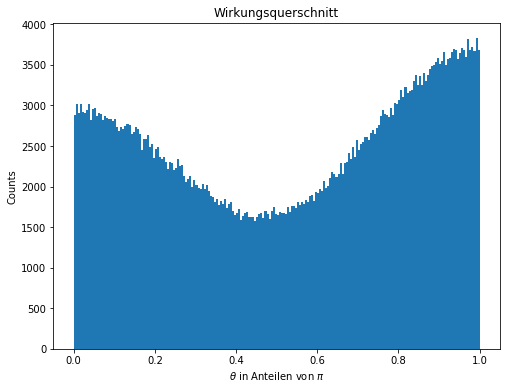

In [6]:
Nevents = 500000  #gewünschte Anzahl der Events
Wi = np.zeros(Nevents)

i=0
old_progress = 0  #Für die Fortschrittsleiste
while i<Nevents:
    rho = np.random.random()
    x = xi(rho)  #Zufallswert zwischen 0 und pi
    Wtest = np.abs(x2-x1)*DW1(s,x)
    if Wtest/Wmax > np.random.random(): #Test, ob der Punkt (x,Wmax*np.random.random()) unter- oder oberhalb
                                        #der Funktion liegt -> Event akzeptieren oder verwerfen
        progress = i/(Nevents-1)
        if progress > old_progress:     #Fortschritt updaten
            old_progress += 0.1
            update_progress(progress)
        
        Wi[i] = xi(rho)                 
        i +=1

#Plot-Routine
fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(Wi/np.pi,200,(0,1)) #Histogramm in Anteilen von pi mit 200 'bins' (Balken) im Intervall 0 bis 1
ax1.set_title('Wirkungsquerschnitt')
ax1.set_xlabel(r'$\theta$ in Anteilen von $\pi$')
ax1.set_ylabel('Counts')
#plt.savefig(fname='Lesefassung/res/LepSpeicherring34GeVEvent.eps',dpi=2000)
plt.show()

Weitere Auswertungsmöglichkeit: Variation der Schwerpunktsenergie im Intervall $70-110$GeV. Dazu wird über alle Winkel integriert -> Die Funktionnen für den diff. Wirkungsquerschnitt müssen angepasst werden. Zusätzlich wird die Integrationsfläche für die Erzeugung von Events optimiert:
$$s=M\Gamma\tan(\rho) + M^2$$
Damit wird der Wirkungsquerschnitt zu 
$$\tilde{\sigma}|_{cm} = \frac{4\pi\alpha^2}{3}\left[F_\gamma\frac{1+\tan^2(\rho)}{\frac{M_Z}{\Gamma_Z}+\tan(\rho)} +F_{Int}A_1\tan(\rho)+F_{Z_0}A_3\left(\tan(\rho)+ \frac{M_z}{\Gamma_Z}\right)\right]$$

In [7]:
#gleiche Aufteilung wie zuvor
def RGamma(rho):
    Fg=Qa**2*Qc**2
    return Fg*(1+np.tan(rho)**2)/(MZ0/FWZ0 +np.tan(rho))
def RInt(rho):
    Fint = Qa*Qc/(cosW*sinW)
    A1 = Cv1*Cv2*0.5
    return Fint*A1*np.tan(rho)
def RZ0(rho):
    Fz = 1/(16.*sinW**2*cosW**2)
    A3 = (Cv1**2+Ca1**2)*(Cv2**2+Ca2**2)
    return Fz*A3*(MZ0/FWZ0 +np.tan(rho))

def DW2(rho):
    return 2.*alpha**2*(RGamma(rho)+RInt(rho)+RZ0(rho))/3.

Vorgehensweise analog nach obigem Beispiel. Zunächst die Berechung des maximalen Funktionswertes über Monte-Carlo Integration und dann Erzeugung der Events.

In [8]:
N=1000000  #Anzahl der Iterationen
W = np.zeros(N)
Wmax = 0.
I = 0.
Qabw = 0.
Einheiten = 2*np.pi*(c*h)**2*10**(+16)

x1=np.arctan((70.**2-MZ0**2)/(MZ0*FWZ0))
x2=np.arctan((110.**2-MZ0**2)/(MZ0*FWZ0))

def xi(x):
    return (x2-x1)*x + x1

for i in range(N):  #Berechnung des Integrals & Speicherung des maximalen Funktionswertes
    rho = np.random.random()
    x = xi(rho)
    W[i] = np.abs(x2-x1)*DW2(x)
    if W[i] > Wmax:
        Wmax = W[i]
    I += W[i]
    Qabw += W[i]**2 
I = I/float(N)
sigma = np.sqrt((Qabw/float(N) - I**2)/float(N))

print('Wirkungsquerschnitt: {:05.3f}+-{:05.3f}mub'.format(I*Einheiten,sigma*Einheiten))

Wirkungsquerschnitt: 1.276+-0.000mub


0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 

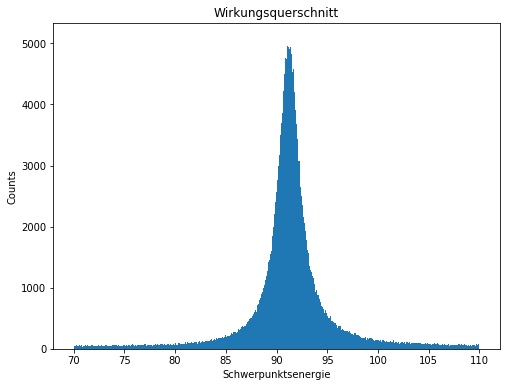

In [9]:
Nevents = 500000  #Anzahl der Events
Wi = np.zeros(Nevents)

i=0
old_progress = 0
while i<Nevents:
    rho = np.random.random()
    x = xi(rho)
    Wtest = np.abs(x2-x1)*DW2(x)
    if Wtest/Wmax > np.random.random():  #Testen des zufälligen Punktes
        
        progress = i/(Nevents-1)         #Fortschritt festhalten
        if progress > old_progress:
            old_progress += 0.1
            update_progress(progress) 
        
        Wi[i] = xi(rho)
        i +=1

#Das Histogramm muss in den alten Variablen dargestellt werden
def s(rho):
    return np.sqrt(MZ0*FWZ0*np.tan(rho) + MZ0**2)  

fig = plt.figure(figsize=(8,6))
ax1 = fig.add_subplot(1,1,1)
ax1.hist(s(Wi),1000,(70,110))  #Histogramm in den alten Variablen
ax1.set_title('Wirkungsquerschnitt')
ax1.set_xlabel('Schwerpunktsenergie')
ax1.set_ylabel('Counts')
#plt.savefig(fname='Lesefassung/res/LepSpeicherringVariationEvent.eps',dpi=2000)
plt.show()

## Hadronischer Speicherring

Hier wird ein Proton Speicherring mit einer Kollisionsenergie von $S=14$TeV modelliert. Die reagierenden Teilchen sind dabei die konstituenten des Protons. Diese haben offensichtlich nicht dieselbe Schwerpunktsenergie, wie die Protonen. Deswegen ist das Schwerpunktsystem in dem Laborsystem, wo die Muonen registriert werden, ein bewegetes und ein Lorentz-Boost liegt vor.

Um die Wahrscheinlichkeit, dass ein Parton bei einem Prozess mit einer bestimmten Energie $\sqrt{\hat{s}}$ teilnimmt, wird durch die Partonverteilungsfunktionen $f_q(x_i,q^2)$ beschrieben.

Da sich nicht unterscheiden lässt, aus welchem der beiden Protonen das Antiteilchen entstammt, sich hierdurch jedoch die Orientierung des Koordinatensystem definiert, muss, um beide Möglichkeiten zu beinhalten, der Prozess zweimal beinhaltet sein. Dabei ist darauf zu achten, dass die Orientierung bei einem um $\pi$ verdreht ist.

Die möglichen Quarks sind das up-, down-, strange-, charme-, top- und bottom-Quark. Die letzten beiden haben jedoch eine hohe Ruheenergie, sodass die Vernachlässigung der Massen keine gute Näherung mehr darstellt. Diese werden hier nicht betrachtet. Das heißt es werden nur vier Quarks miteinbezogen.

Die Quarks werden durch ihren Anteil $x_i$ an dem Impuls ihres Protons beschrieben. Damit gilt für die Kollisionsenergie:
$$\hat{s}=x_1x_2S$$
Um Divergenzen bei niedrigen Kollisionsenergien durch den Photonübergang oder der Partonverteilungsfunktionen zu vermeiden wird eine minimale Energie $\sqrt{S_{min}}=20$GeV eingeführt.

Insgesamt führen diese Effekte zu einem modifiziertem Wirkungsquerschnitt:
$$\frac{\mathrm{d}\sigma}{\mathrm{d}\!\cos(\theta)}= \frac{1}{3}\sum_{q,\bar{q}}\int_{S_\text{min}}^{S}\mathrm{d}\hat{s}\int_{0}^{1}\mathrm{d}x_1\int_{0}^{1}\mathrm{d}x_2\,\delta(Sx_1x_2-\hat{s}) \left[ f_q(x_1,\hat{s})f_{\bar{q}}(x_2,\hat{s})\frac{\mathrm{d}\hat{\sigma}(\hat{s},\cos(\theta))}{\mathrm{d}\!\cos(\theta)} + f_q(x_2,\hat{s})f_{\bar{q}} (x_1,\hat{s})\frac{\mathrm{d}\hat{\sigma}(\hat{s},-\cos(\theta))}{\mathrm{d}\!\cos(\theta)}\right]$$

Substitutionen von $\tau=\hat{s}/S$ und $y=\frac{1}{2}\ln(\frac{x_1}{x_2})$ und Eliminierung der $\delta$-Funktion führen auf:
$$\frac{\mathrm{d}\sigma}{\mathrm{d}\!\cos(\theta)}= \frac{1}{3}\sum_{q,\bar{q}}\int_{S_\text{min}/S}^{1}\mathrm{d}\tau\int_{\frac{1}{2}\ln(\tau)}^{-\frac{1}{2}\ln(\tau)}\mathrm{d}y\,\left[f_q(\sqrt{\tau}e^y,\tau S)f_{\bar{q}}(\sqrt{\tau}e^{-y},\tau S)\frac{\mathrm{d}\hat{\sigma}\left(\frac{\tau}{S},\cos(\theta)\right)}{\mathrm{d}\!\cos(\theta)} + f_q(\sqrt{\tau}e^{-y},\tau S)f_{\bar{q}}(\sqrt{\tau}e^{y},\tau S)\frac{\mathrm{d}\hat{\sigma}\left(\frac{\tau}{S},-\cos(\theta)\right)}{\mathrm{d}\!\cos(\theta)}\right]$$
Mit der bekannten Substitution von $\tau S=\hat{s} = M\Gamma\tan(\rho) + M^2$ wird versucht den Integrationsbereich für die Monte-Carlo-Generation zu optimieren.

Für die Kinematik werden die Impulse im Laborsystem mit groß geschriebenen Buchstaben bezeichnet und die Impulse im Schwerpunktsystem der Quarks mit klein geschriebenen Buchstaben bezeichnet. Es gilt: $p_1=x_1P_A$ & $p_2=x_2P_B$

$$P_A = \left(\begin{array}{c}\frac{\sqrt{S}}{2}\\0\\0\\\frac{\sqrt{S}}{2}\end{array}\right) \qquad P_B = \left(\begin{array}{c}\frac{\sqrt{S}}{2}\\0\\0\\-\frac{\sqrt{S}}{2}\end{array}\right) \qquad P=\left(\begin{array}{c}(x_1+x_2)\frac{\sqrt{S}}{2}\\0\\0\\(x_1-x_2)\frac{\sqrt{S}}{2}\end{array}\right)$$

$P$ ist der Gesamtimpuls der Quarks. Für die Muonen lässt sich für beide Systeme folgende Parametrisierung finden:

$$	p_\mu = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}1\\\cos(\varphi)\sin(\theta)\\\sin(\varphi)\sin(\theta)\\\cos(\theta)\end{array}\right) \qquad 	p_{\bar{\mu}} = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}1\\-\cos(\varphi)\sin(\theta)\\-\sin(\varphi)\sin(\theta)\\-\cos(\theta)\end{array}\right)$$

$$P_\mu = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}\gamma(1-\beta\cos(\theta))\\\cos(\varphi)\sin(\theta)\\\sin(\varphi)\sin(\theta)\\\gamma(\cos(\theta)-\beta)\end{array}\right)\qquad P_{\bar{\mu}} = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}\gamma(1+\beta\cos(\theta))\\-\cos(\varphi)\sin(\theta)\\-\sin(\varphi)\sin(\theta)\\-\gamma(\cos(\theta)+\beta)\end{array}\right)$$

Mit den üblichen ausdrücken $\gamma=\frac{1}{\sqrt{1-\beta^2}}$ und $\beta=\frac{v}{c}=\frac{x_1-x_2}{x_1+x_2}$

### Zur Veranschaulichung: Parton-Verteilungsfunktionen

Zunächst werden die nötigen Pakete geladen um die PDF's verwenden zu können. Falls man selbst Code ausführen möchte, muss man LHAPDF installieren, sich ein PDF-Paket runterladen und entsprechend den Pfad richtig setzen. Es wäre ebenfalls möglich sich selbst Funktionen zu schreiben und so PDf's simulieren.
Die folgende Box nicht mehrmals ausführen, da der Pfad sonst jedes mal neu angehängt wird.

In [10]:
#Nicht mehrmals kompilieren
import sys  #den Pfad für python anhängen, damit die PDF's gefunden werden können
sys.path.append('/home/peter/LHAPDF/lib/python3.6/site-packages') #selber den richtigen Pfad einfügen!

In [11]:
import lhapdf
proton = lhapdf.mkPDF("CT14nlo", 0)  #Ein Proton "erzeugen" mit dem PDF-Paket 'CT14nlo'; dies kann nun 
                                     #aufgerufen werden, um die numerischen Werte der PDF's zu erhalten

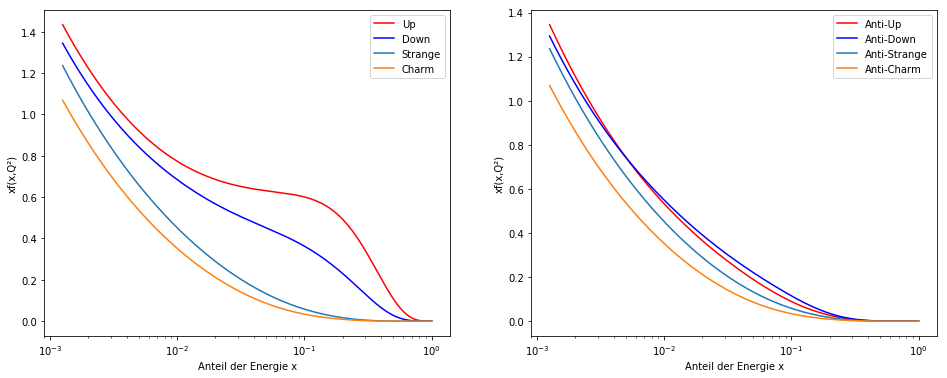

In [12]:
#Parton-Verteilungsfunktionen-Plot
xvals = np.logspace(-2.9,-0.001,1000)  #Werte-Bereich für die Impulsanteile x_i

#up-, down-, strange-, charme-Quarks
up = np.zeros(1000)                    
down =np.zeros(1000)
strange =np.zeros(1000)
charm=np.zeros(1000)

#die korrespondierenden Anti-Quarks
aup = np.zeros(1000)
adown =np.zeros(1000)
astrange =np.zeros(1000)
acharm=np.zeros(1000)

for i in range(1000):  #Die Verteilungsfunktionen auswerten
                       #Achtung: Plot von x*f_q(x,s) 
    up[i] =proton.xfxQ2(2,xvals[i],90**2)
    down[i] =proton.xfxQ2(1,xvals[i],90**2)
    strange[i] =proton.xfxQ2(3,xvals[i],90**2)
    charm[i] =proton.xfxQ2(4,xvals[i],90**2)
    
    aup[i] =proton.xfxQ2(-2,xvals[i],90**2)
    adown[i] =proton.xfxQ2(-1,xvals[i],90**2)
    astrange[i] =proton.xfxQ2(-3,xvals[i],90**2)
    acharm[i] =proton.xfxQ2(-4,xvals[i],90**2)

#Plot-Routine
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,2,1)
ax1.plot(xvals,up,label='Up',color='red')
ax1.plot(xvals,down,label='Down',color='blue')
ax1.plot(xvals,strange,label='Strange')
ax1.plot(xvals,charm,label='Charm')

ax1.set_xscale('log')
ax1.legend(loc='best')
ax1.set_xlabel('Anteil der Energie x')
ax1.set_ylabel('xf(x,Q²)')

ax2 = fig.add_subplot(1,2,2)
ax2.plot(xvals,aup,label='Anti-Up',color='red')
ax2.plot(xvals,adown,label='Anti-Down',color='blue')
ax2.plot(xvals,astrange,label='Anti-Strange')
ax2.plot(xvals,acharm,label='Anti-Charm')

ax2.set_xscale('log')
ax2.legend(loc='best')
ax2.set_xlabel('Anteil der Energie x')
ax2.set_ylabel('xf(x,Q²)')

plt.show()

### Vorgehensweise
1. Definition der Funktionen um den obigen Wirkungsquerschnitt zu berechnen
2. Ausführen der Integrale und Maximalwert speichern 
    1. diesmal ist keine analytische Verteilung gegeben, deswegen ist die Monte-Carlo-Integration besonders hilfreich
3. Eventgenerierung
4. Darstellung der Ergebnisse
    1. Filterung notwendig wegen dem Lorentz-Boost

#### 1. Definition von Funktionen

In [13]:
#Differenzieller Wirkungsquerschnitt in drei Teilen; integriert über \phi 0->2*pi
#Energieabhängige Teile substituiert mit s=M*\Gamma*tan(\rho) + M**2

#|Rgamma|**2
def RGWin(cos): #nicht notwendige Teilung in Winkel- und Energieabhängige Anteile
    return 1+cos**2
def RGEn(rho):
    return (1+np.tan(rho)**2)/(np.tan(rho) + MZ0/FWZ0)
def RGGes(rho,cos,Qa,Qc):
    return RGWin(cos)*RGEn(rho)*Qa**2*Qc**2

#Interferenzterm
def RIntWin(cos,Cv1,Cv2,Ca1,Ca2):
    A = 2.*Cv1*Cv2
    B = 4.*Ca1*Ca2
    return A*(1.+cos**2) + B*cos
def RIntEn(rho):
    return np.tan(rho)
def RIntGes(rho,cos,Qa,Qc,Cv1,Cv2,Ca1,Ca2):
    return RIntWin(cos,Cv1,Cv2,Ca1,Ca2)*RIntEn(rho)*Qa*Qc/(4.*cosW*sinW)

#|RZ0|**2
def RZ0Win(cos,Cv1,Cv2,Ca1,Ca2):
    C = (Cv1**2+Ca1**2)*(Cv2**2+Ca2**2)
    D = 8*Cv1*Cv2*Ca1*Ca2
    return C*(1.+cos**2) + D*cos
def RZ0En(rho):
    return np.tan(rho) + MZ0/FWZ0
def RZ0Ges(s,cos,Cv1,Cv2,Ca1,Ca2):
    return RZ0Win(cos,Cv1,Cv2,Ca1,Ca2)*RZ0En(rho)/(4.*cosW*sinW)**2

#Gesamte Wechselwirkung
def hatDW(rho,cos,quark): 
    #Kopplungen Muon
    Qc = -1.    
    T3c = -0.5 
    Cv2 = T3c-2.*sinW*Qc
    Ca2 = T3c  
    #Kopplungen quarks
    #Unterscheidung zwischen up-type und down-type Quarks, da diese unterschiedliche Kopplungen besitzen
    if quark == 1:
        #up & charm
        Qa = 2./3.       
        T3a = 0.5  
    elif quark == 2:
        #down & strange
        Qa = -1/3.
        T3a = -0.5
    Cv1 = T3a-2.*sinW*Qa    
    Ca1 = T3a
    return RGGes(rho,cos,Qa,Qc)+RIntGes(rho,cos,Qa,Qc,Cv1,Cv2,Ca1,Ca2)+RZ0Ges(rho,cos,Cv1,Cv2,Ca1,Ca2)

In [14]:
#Einbeziehung aller Quarktypen
def sigmaZ(x1,x2,s,rho,cos):
    #up- & charm-Quarks -> quark=1
    value = hatDW(rho,cos,1)*(proton.xfxQ2(2,x1,s)*proton.xfxQ2(-2,x2,s) + proton.xfxQ2(4,x1,s)*proton.xfxQ2(-4,x2,s))/(x1*x2) 
    value += hatDW(rho,-cos,1)*(proton.xfxQ2(2,x2,s)*proton.xfxQ2(-2,x1,s) + proton.xfxQ2(4,x2,s)*proton.xfxQ2(-4,x1,s))/(x1*x2) 
    #down- & strange-Quarks -> quark=2
    value += hatDW(rho,cos,2)*(proton.xfxQ2(1,x1,s)*proton.xfxQ2(-1,x2,s) + proton.xfxQ2(3,x1,s)*proton.xfxQ2(-3,x2,s))/(x1*x2) 
    value += hatDW(rho,-cos,2)*(proton.xfxQ2(1,x2,s)*proton.xfxQ2(-1,x1,s) + proton.xfxQ2(3,x2,s)*proton.xfxQ2(-3,x1,s))/(x1*x2)
    return value

In [15]:
# relativistic functions
def beta(x1,x2):
    return (x2-x1)/(x1+x2)
def gamma(x1,x2):
    return 1./np.sqrt(1-beta(x1,x2)**2)

#### 2. Integral berechnen & Maximalwert bestimmen

<font color='red'>Wichtig: Ab diesem Punkt wird viel Rechenzeit benötigt!</font><br>
Dies liegt an der geringen minimalen Energie, die sowohl die PDF'S, als auch den Photonübergang divergieren lässt. Damit ist der Integrationsbereich nicht mehr optimal flach nach der Substitution.

In [16]:
print(datetime.now().time())
#Integrationsparameter

N = 100000000
S = (8000.)**2   #Strahl-Schwerpunktsenergie
Smin = (20.)**2  #Minimale Energie

W = np.zeros(N)
WmaxSigmaZ = 0.
I = 0.
Qabw = 0.

#Einheiten und Grenzen bestimmen
Einheiten = np.pi*(alpha*h*c*10**11)**2/(6.*S)
RHOminZ = np.arctan((Smin-MZ0**2)/(FWZ0*MZ0))
RHOmaxZ = np.arctan((S-MZ0**2)/(FWZ0*MZ0))
Integralgrenzen = 2.*(RHOmaxZ-RHOminZ)

old_progress = 0
for i in range(N):
    progress = i/(N-1)
    if progress > old_progress:
        old_progress += 0.1
        update_progress(progress)
    #alle Variablen 'würfeln': cos(\theta), rho, t & y
    cos = 2.*np.random.random() - 1.
    rho = RHOminZ + (RHOmaxZ-RHOminZ)*np.random.random()
    t = (MZ0*FWZ0*np.tan(rho)+MZ0**2)/S
    ymax = -0.5*np.log(t)
    y = (2.*np.random.random()-1)*ymax
    x1 = np.sqrt(t)*np.exp(y)
    x2 = np.sqrt(t)*np.exp(-y)
    
    W[i] = 2.*ymax*sigmaZ(x1,x2,t*S,rho,cos)
    if W[i] > WmaxSigmaZ:
        WmaxSigmaZ = W[i]
    I += W[i]
    Qabw += W[i]**2
    
I *= 1./float(N)
sigma = Einheiten*Integralgrenzen*np.sqrt(np.abs(Qabw/float(N) - I**2)/float(N))
I *= Einheiten*Integralgrenzen

print('')
print(datetime.now().time())
print('Integralwert  = '+ str(I) + '+-' + str(sigma) + 'pB')

18:09:12.745128
0% 10% 20% 30% 40% 50% 60% 70% 80% 90% 100% 
18:23:42.788821
Integralwert  = 1396.3858730718514+-6.637715682031055pB


#### 3. Eventgenerierung
<font color='red'>Achtung: Die folgende Berechnung dauert ca. 5 Stunden!</font>

In [17]:
print(datetime.now().time())
Nevents = 100000

#Speichern der relevanten Informationen der akzeptierten Events
WiZ = np.zeros((Nevents,4))           #### Aufbau: [x1,x2,cos(theta),sin(phi)]
EcmZ = np.zeros(Nevents)

i=0
old_progress = 0
while i<Nevents:
    progress = i/(Nevents-1)
    if progress > old_progress:
        old_progress += 0.05
        update_progress(progress)
    #'Würfeln' der Parameter
    cos = 2.*np.random.random() - 1.
    sin = np.sin(2.*np.pi*np.random.random()) #Obwohl sin(\phi) nicht in das Integral eingeht,
                                              #wird dieser zufallsgeneriert, um vollständige Information
                                              #über die entstehenden Teilchen zu erhalten.
                                              #Ist eigentlich nicht notwendig, da dies nicht in die weitere
                                              #Rechnung eingeht.
    rho = RHOminZ + (RHOmaxZ-RHOminZ)*np.random.random()
    t = (MZ0*FWZ0*np.tan(rho)+MZ0**2)/S
    ymax = -0.5*np.log(t)
    y = (2.*np.random.random()-1)*ymax
    x1 = np.sqrt(t)*np.exp(y)
    x2 = np.sqrt(t)*np.exp(-y)
    
    Wtest = 2.*ymax*sigmaZ(x1,x2,t*S,rho,cos)
    if Wtest/WmaxSigmaZ > np.random.random():
        #Daten speichern
        WiZ[i,0]=x1
        WiZ[i,1]=x2
        WiZ[i,2]=cos
        WiZ[i,3]=sin
        EcmZ[i]=np.sqrt(t*S)
        i +=1

print('')
print(datetime.now().time())

18:23:42.797906
0% 5% 10% 15% 20% 25% 30% 35% 40% 45% 50% 55% 60% 65% 70% 75% 80% 85% 90% 95% 
23:41:41.658283


#### 4. Darstellung der Ergebnisse
Die Impulse der entstehenden Muonen zur Erinnerung:

$$P_\mu = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}\gamma(1-\beta\cos(\theta))\\\cos(\varphi)\sin(\theta)\\\sin(\varphi)\sin(\theta)\\\gamma(\cos(\theta)-\beta)\end{array}\right)\qquad P_{\bar{\mu}} = \frac{\sqrt{\hat{s}}}{2}\left(\begin{array}{c}\gamma(1+\beta\cos(\theta))\\-\cos(\varphi)\sin(\theta)\\-\sin(\varphi)\sin(\theta)\\-\gamma(\cos(\theta)+\beta)\end{array}\right)$$

In der Energie- und z-Komponente geht der Lorentz-Boost ein. Um diese Effekte zu filtern, wird stattdessen nach logitudinalem und transversalem Impulsanteilen zerlegt und dessen Betrag als Energie in longitudinaler bzw. transversaler Richtung dargestellt.

$$	\vec{P}_{\mu,\text{long}} = \frac{\hat{s}}{2}\left(\begin{array}{c}0\\0\\\gamma(\cos(\theta)-\beta)\end{array}\right) \qquad \qquad \vec{P}_{\mu,\text{trans}} =\frac{\hat{s}}{2}\left(\begin{array}{c}\cos(\varphi)\sin(\theta)\\\sin(\varphi)\sin(\theta)\\0\end{array}\right)$$

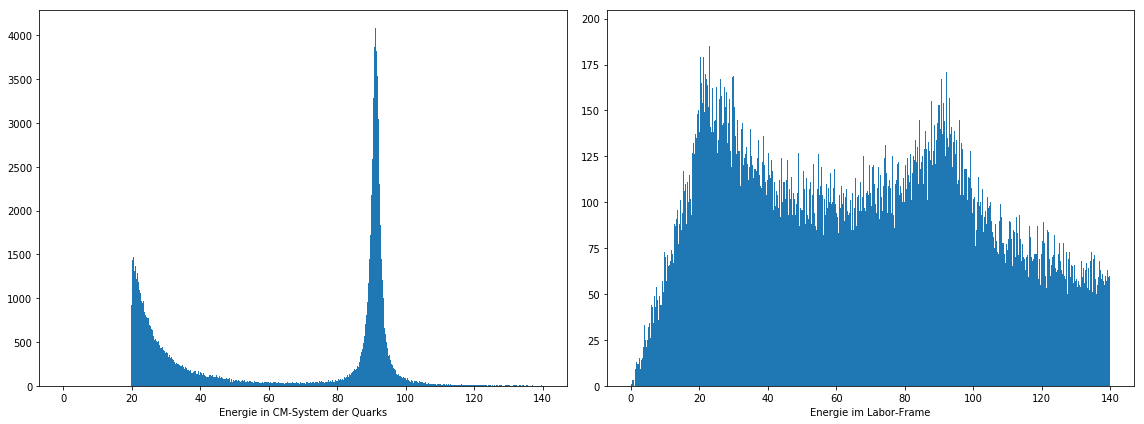

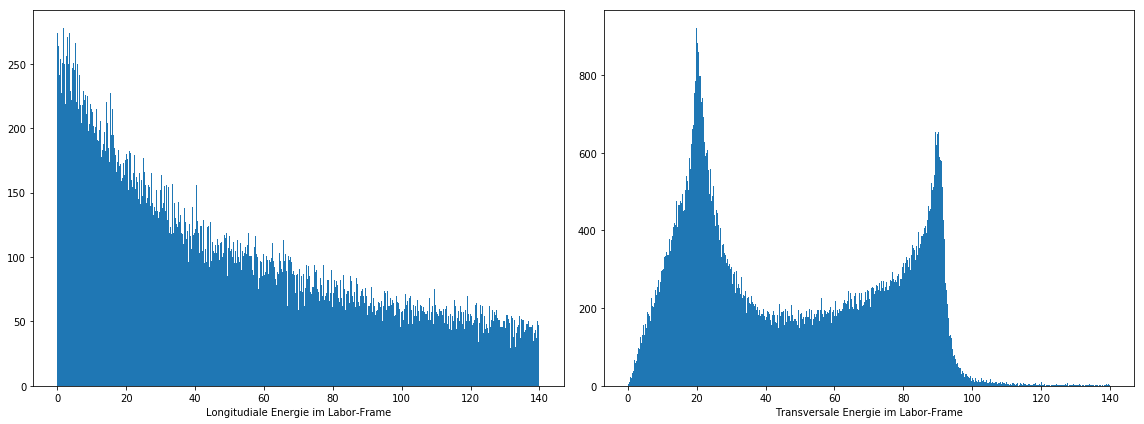

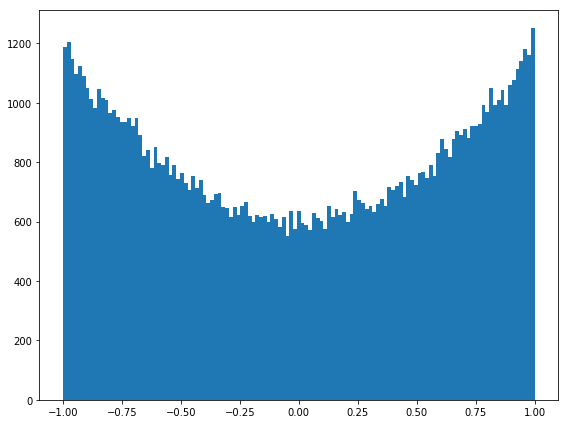

In [19]:
histo = 500

ElabZ=np.zeros(Nevents) #Energie im Laborsystem
ElongZ=np.zeros(Nevents) #Energie in longitudinaler Richtung
EtransZ=np.zeros(Nevents) #Energei in transversaler Richtung

for i in range(Nevents):
    x1=WiZ[i,0]
    x2=WiZ[i,1]
    cos=WiZ[i,2]
    #Berechnungsformeln aus dem (zweifachen) Beträgen des Impulses
    #zweifach, um die Energie von Muon und Antimuon zusammenzunehmen
    ElabZ[i]=EcmZ[i]*np.sqrt(1-cos**2 + gamma(x1,x2)**2*(beta(x1,x2)-cos)**2)
    ElongZ[i]=EcmZ[i]*gamma(x1,x2)*np.abs((beta(x1,x2)-cos))
    EtransZ[i]=EcmZ[i]*np.sqrt(1-cos**2)

#CM-System der Quarks & Laborsystem
fig = plt.figure(figsize=(16,6))
ax1=fig.add_subplot(1,2,1)
ax1.hist(EcmZ,histo,(0,140))
ax1.set_xlabel('Energie in CM-System der Quarks')
ax2=fig.add_subplot(1,2,2)
ax2.hist(ElabZ,histo,(0,140))
ax2.set_xlabel('Energie im Labor-Frame')
plt.tight_layout()
plt.show()

#Longitudinale und Transversale Energien
fig = plt.figure(figsize=(16,6))
ax3=fig.add_subplot(1,2,1)
ax3.hist(ElongZ,histo,(0,140))
ax3.set_xlabel('Longitudiale Energie im Labor-Frame')
ax4=fig.add_subplot(1,2,2)
ax4.hist(EtransZ,histo,(0,140))
ax4.set_xlabel('Transversale Energie im Labor-Frame')
plt.tight_layout()
plt.show()

#Winkelverteilung
fig=plt.figure(figsize=(8,6))
ax1=plt.subplot(1,1,1)
ax1.hist(WiZ[:,2],histo//4,(-1,1))
plt.tight_layout()
plt.show()